# AK spruce beetle outbreak risk pipeline

This notebook is used for creating a climate-based dataset of spruce beetle outbreak risk.

It is currently under development.

In [19]:
import numpy as np
import xarray as xr
from pathlib import Path

In [12]:
met_dir = Path("/workspace/Shared/Tech_Projects/NCAR_AK/met")

In [13]:
tmp_fn = "{}_{}_BCSD_met_{}.nc4"

In [15]:
model = "ACCESS1-3"
scenario = "rcp45"

Define a function that returns a single (bool) value for whether or not "hard" cooling occurred in the array of daily minimum temperatures supplied for a given pixel:

In [127]:
def hard_cooling(arr):
    try:
        idx = np.where(arr <= -12)[0][0]
    except IndexError:
        return False
    
    window = arr[idx:idx + 21]
    avg = np.diff(window).sum() / len(window - 1)
    if avg < -0.5:
        hard_cooling = True
    else:
        hard_cooling = False
        
    return hard_cooling

Define a function that returns a bool for whether or not univoltine conditions were met for supplied sequences of daily minimum and maximum temperatures for a given pixel:

In [299]:
def univoltine(tmin, tmax):
    try:
        idx = np.where(tmax >= 16)[0][0]
    except IndexError:
        return False
    
    tmin = tmin[idx + 40:idx + 90]
    tmax = tmax[idx + 40:idx + 90]
    # hour counter
    k = 0
    # easy if tmin ever above 17
    k += 24 * (tmin > 17).sum()
    # otherwise, multiply percent of temp difference above 17 by 24
    h_est = ((tmax - 17) / (17 - tmin)) / 2 * 24
    h_est[h_est < 0] = 0
    k += h_est.sum()
    
    return k > 200

In [300]:
def compute_risk_arrs(start_year, end_year):
    high_risk = []
    low_risk = []
    for year in np.arange(start_year, end_year):
        yr1_fp = met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year - 1))
        yr2_fp = met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year))
        with xr.open_mfdataset([yr1_fp, yr2_fp]) as ds:
            winter_tmin = ds["tmin"].sel(
                time=slice(f"{year - 1}-07-01", f"{year}-06-30")
            ).values
            tmax = ds["tmax"].sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            ).values
            tmin = ds["tmin"].sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            ).values

        # low risk 
        # bool for whether or not -40 was exceeded
        cold_arr = winter_tmin.min(axis=0) <= -40
        # bool for whether or not hard cooling happened
        cooling_arr = np.apply_along_axis(hard_cooling, 0, winter_tmin)
        # bool for univoltine summer
        univoltine_arr = np.empty(tmin.shape[1:]).astype(bool)
        for i in np.arange(tmin.shape[1]):
            for j in np.arange(tmax.shape[2]):
                univoltine_arr[i,j] = univoltine(tmin[:,i,j], tmax[:,i,j])
        low_risk.append(cold_arr & cooling_arr & ~univoltine_arr)

        # high risk
        # warm minimums
        cold_arr = winter_tmin.min(axis=0) > -20
        # will use same univoltine and cooling arrays as above, for now
        high_risk.append(cold_arr & ~cooling_arr & univoltine_arr)
        
    nodata_mask = np.flipud(np.isnan(winter_tmin[0]))
    high_risk = np.flipud(np.array(high_risk).sum(axis=0)).astype(float)
    low_risk = np.flipud(np.array(low_risk).sum(axis=0)).astype(float)
    high_risk[nodata_mask] = np.nan
    low_risk[nodata_mask] = np.nan
    
    return low_risk, high_risk

Compute arrays for the number of "high risk" years and "low risk" years based on extreme combinations of the three influential criteria.

In [301]:
risk_dict = {"low": {}, "high": {}}

In [302]:
import time


tic = time.perf_counter()

start_year = 1980
end_year = 2009
era = f"{start_year}-{end_year}"
risk_dict["low"][era], risk_dict["high"][era] = compute_risk_arrs(start_year, end_year)
    
print(round(time.perf_counter() - tic), "s")

114 s


In [303]:
tic = time.perf_counter()

start_year = 2020
end_year = 2049
era = f"{start_year}-{end_year}"
risk_dict["low"][era], risk_dict["high"][era] = compute_risk_arrs(start_year, end_year)
    
print(round(time.perf_counter() - tic), "s")

116 s


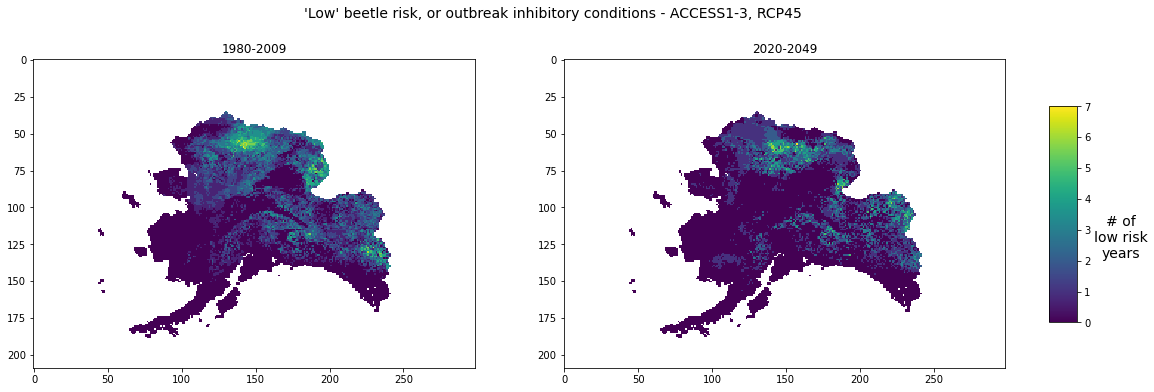

In [304]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for key, ax in zip(risk_dict["low"], axes):
    im = ax.imshow(risk_dict["low"][key], interpolation="none")
    ax.set_title(f"{key}")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('# of\nlow risk\nyears', size=14, rotation=0)

plt.suptitle("'Low' beetle risk, or outbreak inhibitory conditions - ACCESS1-3, RCP45         ", size=14)
plt.show()

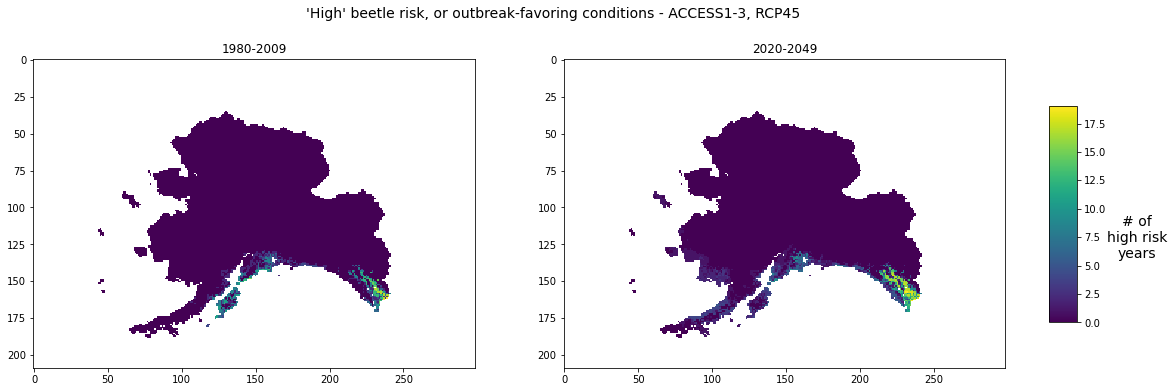

In [305]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for key, ax in zip(risk_dict["high"], axes):
    im = ax.imshow(risk_dict["high"][key], interpolation="none")
    ax.set_title(f"{key}")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('# of\nhigh risk\nyears', size=14, rotation=0)

plt.suptitle("'High' beetle risk, or outbreak-favoring conditions - ACCESS1-3, RCP45         ", size=14)
plt.show()

In [307]:

# count years below -20 C
cold_years = []
for year in np.arange(1980, 2009):
    yr1_fp = met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year - 1))
    yr2_fp = met_dir.joinpath(model, scenario, tmp_fn.format(model, scenario, year))
    with xr.open_mfdataset([yr1_fp, yr2_fp]) as ds:
        winter_tmin = ds["tmin"].sel(
            time=slice(f"{year - 1}-07-01", f"{year}-06-30")
        ).values
        
    cold_years.append(np.flipud(winter_tmin.min(axis=0) < -20))

nodata_mask = np.flipud(np.isnan(winter_tmin[0]))
cold_years = np.array(cold_years).sum(axis=0).astype(float)
cold_years[nodata_mask] = np.nan

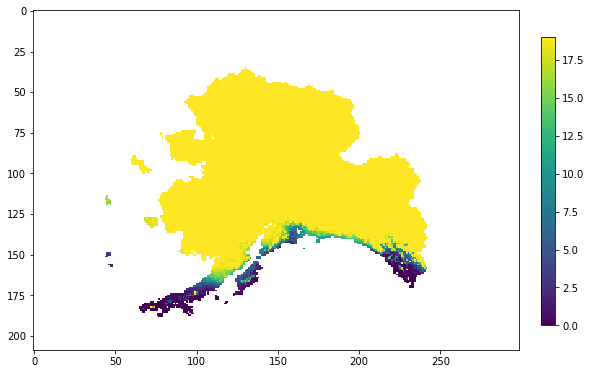

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(cold_years, interpolation="none")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)

plt.show()

In [134]:
test = univoltine(summer_tmin[:,150,150], summer_tmax[:,150,150])

In [136]:
test = np.apply_along_axis(univoltine, 0, summer_tmin, summer_tmax)

ValueError: operands could not be broadcast together with shapes (365,209,299) (365,) 

In [129]:
test = np.apply_along_axis(hard_cooling, 0, winter_tmin)

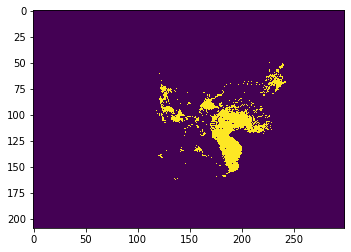

In [130]:
plt.imshow(test, interpolation="none")

In [113]:
arr = winter_tmin[:,150,150]
idx = np.where(arr <= -12)[0][0]

In [121]:
window = arr[idx:idx + 21]
np.diff(window).sum() / len(window - 1)

-0.09523809523809523

In [119]:
window

array([-12.553199, -11.553199,  -8.053199, -10.053199, -14.553199,
       -17.053198, -18.053198, -14.053199, -17.053198, -17.053198,
       -17.053198, -17.053198, -16.053198, -18.553198, -20.053198,
       -21.553198, -22.053198, -21.053198, -18.553198, -16.053198,
       -14.553199], dtype=float32)

In [104]:
winter_tmin = ds["tmin"].sel(
            time=slice(f"{year}-07-01", f"{year + 1}-06-30")
        ).values